In [4]:
!pip install -q gymnasium matplotlib

In [5]:
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Some information about this environment:
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Initial observation: [-0.02553473 -0.02606928 -0.02018729  0.00981744]
Next observation: [-0.02605611 -0.22089598 -0.01999094  0.2960633 ]
Reward: 1.0
Terminated: False
Truncated: False
Info: {}


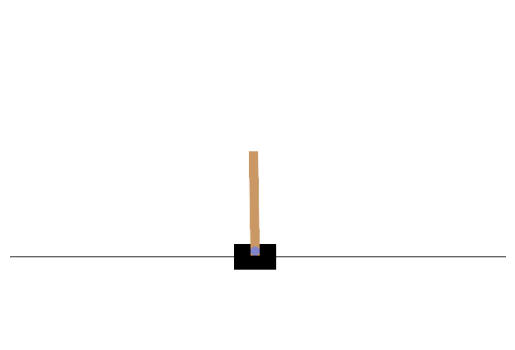

In [6]:

env = gym.make('CartPole-v1', render_mode='rgb_array')

print("Some information about this environment:")
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

obs, _ = env.reset()
print('Initial observation:', obs)

action = env.action_space.sample()
obs, r, terminated, truncated, info = env.step(action)
print('Next observation:', obs)
print('Reward:', r)
print('Terminated:', terminated)
print('Truncated:', truncated)
print('Info:', info)

frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()

In [7]:
class PolicyNetwork(tf.keras.Model):
    def __init__(self, num_actions, hidden_size):
        super(PolicyNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.out = tf.keras.layers.Dense(num_actions, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out(x)

model = PolicyNetwork(env.action_space.n, 128)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [10]:
def train_step(observations, actions, rewards):
    with tf.GradientTape() as tape:
        logits = model(observations)
        action_masks = tf.one_hot(actions, env.action_space.n)
        log_probs = tf.reduce_sum(action_masks * tf.math.log(logits), axis=1)
        loss = -tf.reduce_mean(log_probs * rewards)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def run_episode():
    observations, actions, rewards = [], [], []
    obs, _ = env.reset()
    done = False

    while not done:
        obs = tf.convert_to_tensor(obs, dtype=tf.float32)
        action_probs = model(obs[tf.newaxis, ...])
        action = tf.random.categorical(tf.math.log(action_probs), 1)[0, 0].numpy()


        action = np.clip(action, 0, env.action_space.n - 1)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        observations.append(obs)
        actions.append(action)
        rewards.append(reward)

        obs = next_obs

    return observations, actions, rewards

In [11]:
num_episodes = 1000
for episode in range(num_episodes):
    observations, actions, rewards = run_episode()


    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
        cumulative_reward = reward + 0.99 * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)

    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-8)

    observations = tf.convert_to_tensor(observations, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)

    loss = train_step(observations, actions, discounted_rewards)

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {sum(rewards)}, Loss: {loss.numpy()}")

    if sum(rewards) >= 195:
        print(f"Solved in {episode} episodes!")
        break

Episode 0, Total Reward: 10.0, Loss: nan
Episode 10, Total Reward: 10.0, Loss: nan
Episode 20, Total Reward: 9.0, Loss: nan
Episode 30, Total Reward: 8.0, Loss: nan
Episode 40, Total Reward: 8.0, Loss: nan
Episode 50, Total Reward: 9.0, Loss: nan
Episode 60, Total Reward: 10.0, Loss: nan
Episode 70, Total Reward: 11.0, Loss: nan
Episode 80, Total Reward: 10.0, Loss: nan
Episode 90, Total Reward: 8.0, Loss: nan
Episode 100, Total Reward: 9.0, Loss: nan
Episode 110, Total Reward: 10.0, Loss: nan
Episode 120, Total Reward: 10.0, Loss: nan
Episode 130, Total Reward: 8.0, Loss: nan
Episode 140, Total Reward: 9.0, Loss: nan
Episode 150, Total Reward: 11.0, Loss: nan
Episode 160, Total Reward: 10.0, Loss: nan
Episode 170, Total Reward: 10.0, Loss: nan
Episode 180, Total Reward: 9.0, Loss: nan
Episode 190, Total Reward: 10.0, Loss: nan
Episode 200, Total Reward: 10.0, Loss: nan
Episode 210, Total Reward: 8.0, Loss: nan
Episode 220, Total Reward: 8.0, Loss: nan
Episode 230, Total Reward: 9.0, L

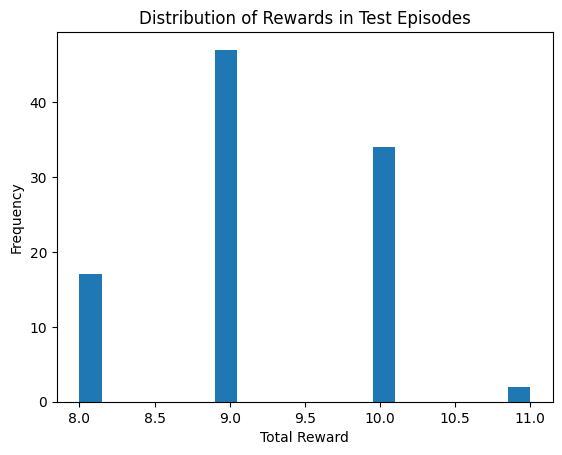

Average Reward over 100 test episodes: 9.21


In [12]:

test_rewards = []
for _ in range(100):
    _, _, rewards = run_episode()
    test_rewards.append(sum(rewards))

plt.hist(test_rewards, bins=20)
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Rewards in Test Episodes')
plt.show()

print(f"Average Reward over 100 test episodes: {np.mean(test_rewards)}")